# **1. Import Library**

Pada tahap ini, Anda perlu mengimpor beberapa pustaka (library) Python yang dibutuhkan untuk analisis data dan pembangunan model machine learning.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split, cross_val_score
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import (
    RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier,
    HistGradientBoostingClassifier, AdaBoostClassifier
)
from sklearn.linear_model import (
    LogisticRegression, LogisticRegressionCV, RidgeClassifier
)
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier

# **2. Memuat Dataset dari Hasil Clustering**

Memuat dataset hasil clustering dari file CSV ke dalam variabel DataFrame.

In [ ]:
df = pd.read_csv('Dataset_clustering.csv')

In [3]:
df

,TransactionAmount,CustomerAge,TransactionDuration,AccountBalance,CustomerOccupation_Doctor,CustomerOccupation_Engineer,CustomerOccupation_Retired,CustomerOccupation_Student,Cluster
0,0.007207,0.838710,0.244828,0.336832,1.0,0.0,0.0,0.0,1
1,0.195940,0.806452,0.451724,0.918055,1.0,0.0,0.0,0.0,1
2,0.065680,0.016129,0.158621,0.068637,0.0,0.0,0.0,1.0,2
3,0.096016,0.129032,0.051724,0.569198,0.0,0.0,0.0,1.0,2
4,0.006874,0.129032,0.648276,0.492591,0.0,0.0,0.0,1.0,2
...,...,...,...,...,...,...,...,...,...
2507,0.446074,0.241935,0.341379,0.846257,1.0,0.0,0.0,0.0,1
2508,0.130953,0.483871,0.575862,0.010318,1.0,0.0,0.0,0.0,1
2509,0.014785,0.612903,0.468966,0.220590,0.0,0.0,1.0,0.0,3
2510,0.096782,0.080645,0.031034,0.112636,0.0,0.0,0.0,1.0,2


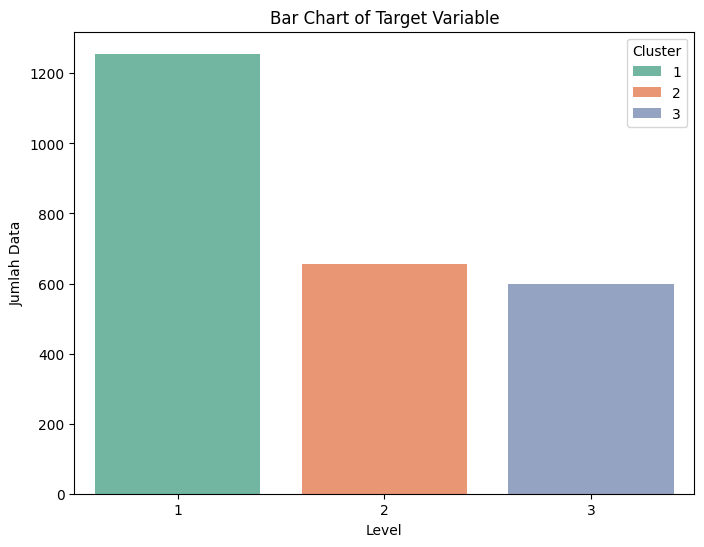

In [4]:
plt.figure(figsize=(8, 6))
sns.countplot(data=df, x='Cluster', hue='Cluster', palette='Set2')
plt.title('Bar Chart of Target Variable')
plt.xlabel('Level')
plt.ylabel('Jumlah Data')
plt.show()

Karena label data tidak seimbang (imbalance), akan dilakukan penanganan dengan SMOTE.

# **3. Data Splitting**

Tahap Data Splitting bertujuan untuk memisahkan dataset menjadi dua bagian: data latih (training set) dan data uji (test set).

In [5]:
X = df.drop(columns=['Cluster'])
y = df['Cluster'] - 1

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [7]:
X_train.shape, X_test.shape

((2009, 8), (503, 8))

In [8]:
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

In [9]:
# Periksa distribusi kelas setelah SMOTE
print("Distribusi kelas sebelum SMOTE:")
print(y_train.value_counts())
print("\nDistribusi kelas setelah SMOTE:")
print(pd.Series(y_train_smote).value_counts())

Distribusi kelas sebelum SMOTE:
Cluster
0    996
1    524
2    489
Name: count, dtype: int64

Distribusi kelas setelah SMOTE:
Cluster
0    996
2    996
1    996
Name: count, dtype: int64


Distribusi kelas data telah seimbang.

# **4. Membangun Model Klasifikasi**


## **a. Membangun Model Klasifikasi**

Setelah memilih algoritma klasifikasi yang sesuai, langkah selanjutnya adalah melatih model menggunakan data latih.

Berikut adalah rekomendasi tahapannya.
1. Pilih algoritma klasifikasi yang sesuai, seperti Logistic Regression, Decision Tree, Random Forest, atau K-Nearest Neighbors (KNN).
2. Latih model menggunakan data latih.

In [10]:
# Fungsi evaluasi model
def all_model(list_model, X_train, X_val, y_train, y_val):
    result = []
    for model_name, model in list_model.items():
        model.fit(X_train, y_train)
        y_pred = model.predict(X_val)
        
        accuracy = accuracy_score(y_val, y_pred)
        precision = precision_score(y_val, y_pred, average='weighted')
        recall = recall_score(y_val, y_pred, average='weighted')
        f1 = f1_score(y_val, y_pred, average='weighted')

        hasil = {
            'Model': model_name,
            'Accuracy': accuracy,
            'F1 Score': f1,
            'Precision': precision,
            'Recall': recall
        }

        result.append(hasil)
    
    return pd.DataFrame(result).sort_values(by="Accuracy", ascending=False)

# Daftar model 
list_of_model = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Logistic Regression CV": LogisticRegressionCV(max_iter=10000),
    "Ridge Classifier": RidgeClassifier(),
    "Support Vector Machine": SVC(),
    "K-Nearest Neighbors": KNeighborsClassifier(n_neighbors=5),
    "Naive Bayes Gaussian": GaussianNB(),
    "Naive Bayes Bernoulli": BernoulliNB(),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "Extra Trees": ExtraTreesClassifier(n_estimators=100, random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(n_estimators=100, random_state=42),
    "Hist Gradient Boosting": HistGradientBoostingClassifier(random_state=42),
    "AdaBoost": AdaBoostClassifier(n_estimators=100, random_state=42),
    "XGBoost": XGBClassifier(random_state=42),
    "CatBoost": CatBoostClassifier(random_state=42, logging_level='Silent'),
    "LightGBM": LGBMClassifier(random_state=42)
}

In [11]:
results = all_model(list_of_model, X_train_smote, X_test, y_train_smote, y_test)
results

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000953 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1028
[LightGBM] [Info] Number of data points in the train set: 2988, number of used features: 8
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further split

,Model,Accuracy,F1 Score,Precision,Recall
0,Logistic Regression,1.0,1.0,1.0,1.0
1,Logistic Regression CV,1.0,1.0,1.0,1.0
2,Ridge Classifier,1.0,1.0,1.0,1.0
3,Support Vector Machine,1.0,1.0,1.0,1.0
4,K-Nearest Neighbors,1.0,1.0,1.0,1.0
5,Naive Bayes Gaussian,1.0,1.0,1.0,1.0
6,Naive Bayes Bernoulli,1.0,1.0,1.0,1.0
7,Decision Tree,1.0,1.0,1.0,1.0
8,Random Forest,1.0,1.0,1.0,1.0
9,Extra Trees,1.0,1.0,1.0,1.0


Seluruh algoritma yang diterapkan menampilkan hasil akurasi yang sangat baik, sehingga dicurigai terjadi overfitting. Oleh karena itu, akan dipilih algoritma Logistic Regression dan Support Vector Machine karena memiliki kemampuan regularisasi yang baik untuk menghindari overfitting.

## **Logistic Regression**
Logistic Regression adalah algoritma klasifikasi yang digunakan untuk memprediksi probabilitas suatu kelas berdasarkan fitur input. Logistic Regression menggunakan fungsi sigmoid untuk mengubah output dari model menjadi probabilitas yang terletak antara 0 dan 1. Berdasarkan probabilitas ini, data kemudian dikategorikan ke dalam kelas tertentu. Logistic Regression memiliki kemampuan untuk regularisasi menggunakan L1 (Lasso) atau L2 (Ridge), yang membantu menghindari overfitting.
- **L1 regularization (Lasso)**: Menghasilkan model dengan koefisien yang lebih sedikit (sparse), dengan memaksa beberapa koefisien menjadi nol, yang berguna dalam feature selection.
- **L2 regularization (Ridge)**: Mengurangi nilai koefisien tanpa membuatnya nol, yang membantu mengurangi kompleksitas model dan overfitting.

## **Support Vector Machine**
Support Vector Machine (SVM) adalah algoritma klasifikasi yang mencari hyperplane optimal yang memisahkan data ke dalam dua kelas. Tujuan SVM adalah menemukan hyperplane yang memiliki margin terbesar antara kelas yang berbeda. Dalam SVM, regularisasi dilakukan dengan mengontrol parameter C dan pemilihan kernel untuk menyeimbangkan antara memperbesar margin dan mengurangi kesalahan pada data pelatihan.
SVM dengan regularisasi digunakan untuk menghindari overfitting dengan cara mengontrol kompleksitas model, terutama ketika data sangat terpisah (seperti data yang memiliki margin yang sangat jelas).

## **b. Evaluasi Model Klasifikasi**

Berikut adalah **rekomendasi** tahapannya.
1. Lakukan prediksi menggunakan data uji.
2. Hitung metrik evaluasi seperti Accuracy dan F1-Score (Opsional: Precision dan Recall).
3. Buat confusion matrix untuk melihat detail prediksi benar dan salah.

### **b.1 Logistic Regression**

In [12]:
logistic_model = LogisticRegression(max_iter=1000)
logistic_model.fit(X_train_smote, y_train_smote)

LogisticRegression(max_iter=1000)

In [13]:
y_pred_lr = logistic_model.predict(X_test)
print("\nClassification Report:\n", classification_report(y_test, y_pred_lr))


Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       260
           1       1.00      1.00      1.00       133
           2       1.00      1.00      1.00       110

    accuracy                           1.00       503
   macro avg       1.00      1.00      1.00       503
weighted avg       1.00      1.00      1.00       503



In [14]:
accuracy_lr = accuracy_score(y_test, y_pred_lr)
f1_value_lr = f1_score(y_test, y_pred_lr, average='weighted') 
precision_lr = precision_score(y_test, y_pred_lr, average='weighted')
recall_lr = recall_score(y_test, y_pred_lr, average='weighted')

print("Accuracy:", accuracy_lr)
print("F1 Score:", f1_value_lr)  
print("Precision:", precision_lr)
print("Recall:", recall_lr)

Accuracy: 1.0
F1 Score: 1.0
Precision: 1.0
Recall: 1.0


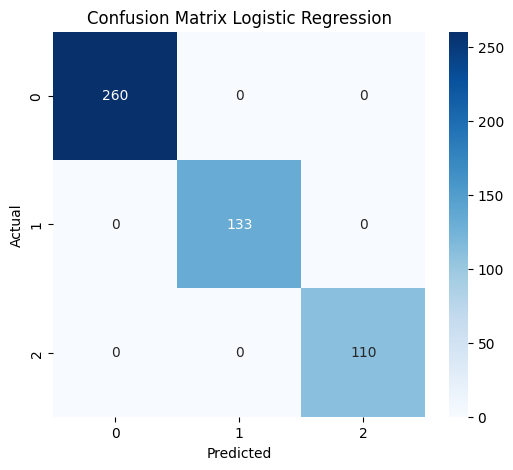

In [15]:
cm_lr = confusion_matrix(y_test, y_pred_lr)

plt.figure(figsize=(6, 5))
sns.heatmap(cm_lr, annot=True, fmt="d", cmap="Blues", xticklabels=set(y_test), yticklabels=set(y_test))
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix Logistic Regression")
plt.show()

Karena dicurigai terjadi overfitting, akan dilakukan cross-validation dan regularization.

#### **b.1.1 Cross-Validation**

In [16]:
lr_cv_model = LogisticRegression(max_iter=1000)

# Cross-validation dengan 5 fold
lr_cv_scores = cross_val_score(lr_cv_model, X_train_smote, y_train_smote, cv=5, scoring='f1_weighted')

print("Cross-validation scores:", lr_cv_scores)
print("Mean F1-Weighted:", lr_cv_scores.mean())

Cross-validation scores: [1. 1. 1. 1. 1.]
Mean F1-Weighted: 1.0


In [17]:
lr_cv_model.fit(X_train_smote, y_train_smote)

y_pred_lr_cv = lr_cv_model.predict(X_test)
print("\nClassification Report:\n", classification_report(y_test, y_pred_lr_cv))


Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       260
           1       1.00      1.00      1.00       133
           2       1.00      1.00      1.00       110

    accuracy                           1.00       503
   macro avg       1.00      1.00      1.00       503
weighted avg       1.00      1.00      1.00       503



In [18]:
accuracy_lr_cv = accuracy_score(y_test, y_pred_lr_cv)
f1_score_lr_cv = f1_score(y_test, y_pred_lr_cv, average='weighted')
precision_lr_cv = precision_score(y_test, y_pred_lr_cv, average='weighted')
recall_lr_cv = recall_score(y_test, y_pred_lr_cv, average='weighted')

print("Accuracy:", accuracy_lr_cv)
print("F1 Score:", f1_score_lr_cv)  
print("Precision:", precision_lr_cv)
print("Recall:", recall_lr_cv)

Accuracy: 1.0
F1 Score: 1.0
Precision: 1.0
Recall: 1.0


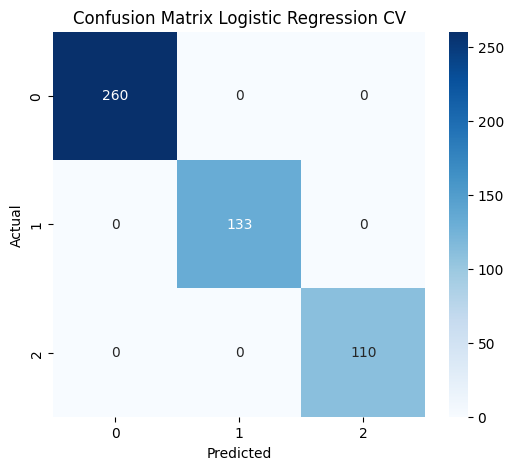

In [19]:
cm_lr_cv = confusion_matrix(y_test, y_pred_lr_cv)

plt.figure(figsize=(6, 5))
sns.heatmap(cm_lr_cv, annot=True, fmt="d", cmap="Blues", xticklabels=set(y_test), yticklabels=set(y_test))
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix Logistic Regression CV")
plt.show()

#### **b.1.2 Regularization**

In [20]:
# Regularisasi dengan penalti L2
lr_reg_model = LogisticRegression(penalty='l2', max_iter=1000)
lr_reg_model.fit(X_train_smote, y_train_smote)

LogisticRegression(max_iter=1000)

In [21]:
y_pred_lr_reg = lr_reg_model.predict(X_test)
print("\nClassification Report:\n", classification_report(y_test, y_pred_lr_reg))


Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       260
           1       1.00      1.00      1.00       133
           2       1.00      1.00      1.00       110

    accuracy                           1.00       503
   macro avg       1.00      1.00      1.00       503
weighted avg       1.00      1.00      1.00       503



In [22]:
accuracy_lr_reg = accuracy_score(y_test, y_pred_lr_reg)
f1_score_lr_reg = f1_score(y_test, y_pred_lr_reg, average='weighted')
precision_lr_reg = precision_score(y_test, y_pred_lr_reg, average='weighted')
recall_lr_reg = recall_score(y_test, y_pred_lr_reg, average='weighted')

print("Accuracy:", accuracy_lr_reg)
print("F1 Score:", f1_score_lr_reg)  
print("Precision:", precision_lr_reg)
print("Recall:", recall_lr_reg)

Accuracy: 1.0
F1 Score: 1.0
Precision: 1.0
Recall: 1.0


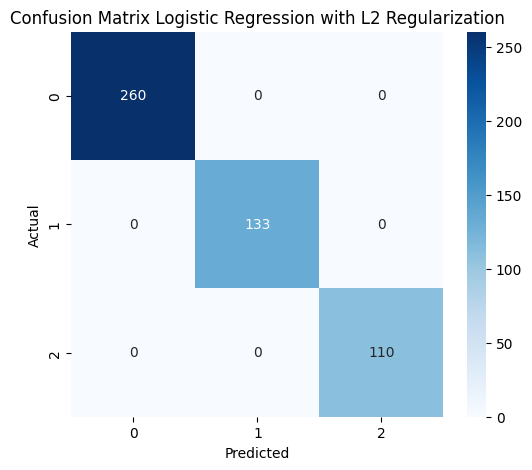

In [23]:
cm_lr_reg = confusion_matrix(y_test, y_pred_lr_reg)

plt.figure(figsize=(6, 5))
sns.heatmap(cm_lr_reg, annot=True, fmt="d", cmap="Blues", xticklabels=set(y_test), yticklabels=set(y_test))
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix Logistic Regression with L2 Regularization")
plt.show()

### **b.2 Support Vector Machine**

In [24]:
svm_model = SVC()
svm_model.fit(X_train_smote, y_train_smote)

SVC()

In [25]:
y_pred_svm = svm_model.predict(X_test)
print("\nClassification Report:\n", classification_report(y_test, y_pred_svm))


Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       260
           1       1.00      1.00      1.00       133
           2       1.00      1.00      1.00       110

    accuracy                           1.00       503
   macro avg       1.00      1.00      1.00       503
weighted avg       1.00      1.00      1.00       503



In [26]:
accuracy_svm = accuracy_score(y_test, y_pred_svm)
f1_value_svm = f1_score(y_test, y_pred_svm, average='weighted') 
precision_svm = precision_score(y_test, y_pred_svm, average='weighted')
recall_svm = recall_score(y_test, y_pred_svm, average='weighted')

print("Accuracy:", accuracy_svm)
print("F1 Score:", f1_value_svm)  
print("Precision:", precision_svm)
print("Recall:", recall_svm)

Accuracy: 1.0
F1 Score: 1.0
Precision: 1.0
Recall: 1.0


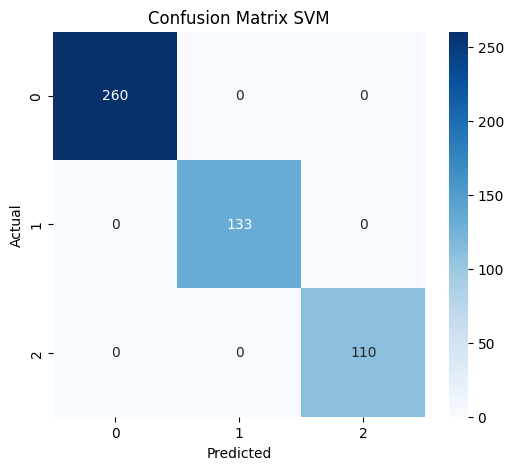

In [27]:
cm_svm = confusion_matrix(y_test, y_pred_svm)

plt.figure(figsize=(6, 5))
sns.heatmap(cm_svm, annot=True, fmt="d", cmap="Blues", xticklabels=set(y_test), yticklabels=set(y_test))
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix SVM")
plt.show()

Karena dicurigai terjadi overfitting, akan dilakukan cross-validation dan regularization.

#### **b.2.1 Cross-Validation**

In [28]:
svm_cv_model = SVC()

# Cross-validation dengan 5 fold
svm_cv_scores = cross_val_score(svm_cv_model, X_train_smote, y_train_smote, cv=5, scoring='f1_weighted')

print("Cross-validation scores:", svm_cv_scores)
print("Mean F1-Weighted:", svm_cv_scores.mean())

Cross-validation scores: [1. 1. 1. 1. 1.]
Mean F1-Weighted: 1.0


In [29]:
svm_cv_model.fit(X_train_smote, y_train_smote)

y_pred_svm_cv = svm_cv_model.predict(X_test)
print("\nClassification Report:\n", classification_report(y_test, y_pred_svm_cv))


Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       260
           1       1.00      1.00      1.00       133
           2       1.00      1.00      1.00       110

    accuracy                           1.00       503
   macro avg       1.00      1.00      1.00       503
weighted avg       1.00      1.00      1.00       503



In [30]:
accuracy_svm_cv = accuracy_score(y_test, y_pred_svm_cv)
f1_score_svm_cv = f1_score(y_test, y_pred_svm_cv, average='weighted')
precision_svm_cv = precision_score(y_test, y_pred_svm_cv, average='weighted')
recall_svm_cv = recall_score(y_test, y_pred_svm_cv, average='weighted')

print("Accuracy:", accuracy_svm_cv)
print("F1 Score:", f1_score_svm_cv)  
print("Precision:", precision_svm_cv)
print("Recall:", recall_svm_cv)

Accuracy: 1.0
F1 Score: 1.0
Precision: 1.0
Recall: 1.0


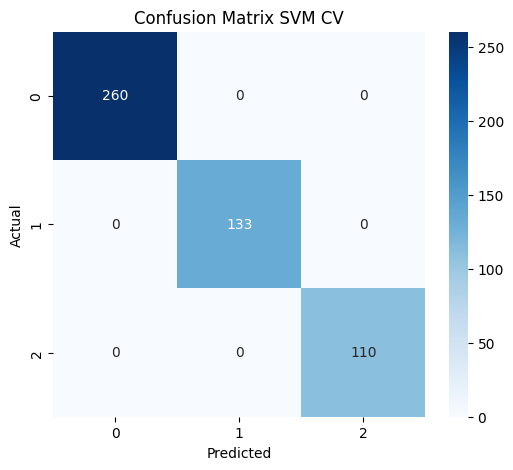

In [31]:
cm_svm_cv = confusion_matrix(y_test, y_pred_svm_cv)

plt.figure(figsize=(6, 5))
sns.heatmap(cm_svm_cv, annot=True, fmt="d", cmap="Blues", xticklabels=set(y_test), yticklabels=set(y_test))
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix SVM CV")
plt.show()

#### **b.2.2 Regularization**

In [32]:
# Regularisasi dengan parameter C
svm_reg_model = SVC(C=0.5, kernel='linear')
svm_reg_model.fit(X_train_smote, y_train_smote)

SVC(C=0.5, kernel='linear')

In [33]:
y_pred_svm_reg = svm_reg_model.predict(X_test)
print("\nClassification Report:\n", classification_report(y_test, y_pred_svm_reg))


Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       260
           1       1.00      1.00      1.00       133
           2       1.00      1.00      1.00       110

    accuracy                           1.00       503
   macro avg       1.00      1.00      1.00       503
weighted avg       1.00      1.00      1.00       503



In [34]:
accuracy_svm_reg = accuracy_score(y_test, y_pred_svm_reg)
f1_score_svm_reg = f1_score(y_test, y_pred_svm_reg, average='weighted')
precision_svm_reg = precision_score(y_test, y_pred_svm_reg, average='weighted')
recall_svm_reg = recall_score(y_test, y_pred_svm_reg, average='weighted')

print("Accuracy:", accuracy_svm_reg)
print("F1 Score:", f1_score_svm_reg)
print("Precision:", precision_svm_reg)
print("Recall:", recall_svm_reg)

Accuracy: 1.0
F1 Score: 1.0
Precision: 1.0
Recall: 1.0


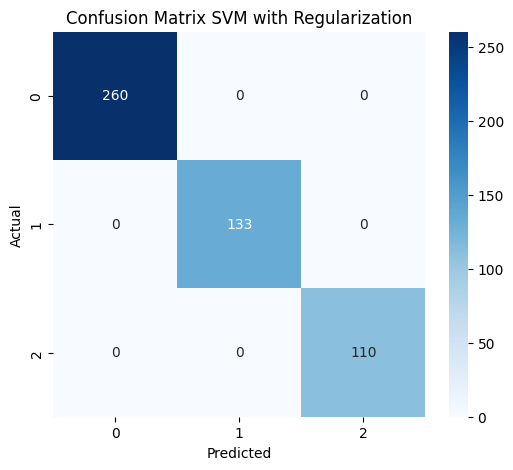

In [35]:
cm_svm_reg = confusion_matrix(y_test, y_pred_svm_reg)

plt.figure(figsize=(6, 5))
sns.heatmap(cm_svm_reg, annot=True, fmt="d", cmap="Blues", xticklabels=set(y_test), yticklabels=set(y_test))
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix SVM with Regularization")
plt.show()

### **Perbandingan**

Tulis hasil evaluasi algoritma yang digunakan, jika Anda menggunakan 2 algoritma, maka bandingkan hasilnya.

In [36]:
comparison_results = pd.DataFrame({
    "Algoritma": [
        "Logistic Regression", "Logistic Regression", "Logistic Regression", 
        "SVM", "SVM", "SVM"
    ],
    "Metode": [
        "Tanpa Regularisasi", "Cross-Validation", "Regularisasi", 
        "Tanpa Regularisasi", "Cross-Validation", "Regularisasi"
    ],
    "Accuracy": [
        accuracy_lr, accuracy_lr_cv, accuracy_lr_reg, 
        accuracy_svm, accuracy_svm_cv, accuracy_svm_reg
    ],
    "F1 Score": [
        f1_value_lr, f1_score_lr_cv, f1_score_lr_reg, 
        f1_value_svm, f1_score_svm_cv, f1_score_svm_reg
    ],
    "Precision": [
        precision_lr, precision_lr_cv, precision_lr_reg, 
        precision_svm, precision_svm_cv, precision_svm_reg
    ],
    "Recall": [
        recall_lr, recall_lr_cv, recall_lr_reg, 
        recall_svm, recall_svm_cv, recall_svm_reg
    ]
})

comparison_results

,Algoritma,Metode,Accuracy,F1 Score,Precision,Recall
0,Logistic Regression,Tanpa Regularisasi,1.0,1.0,1.0,1.0
1,Logistic Regression,Cross-Validation,1.0,1.0,1.0,1.0
2,Logistic Regression,Regularisasi,1.0,1.0,1.0,1.0
3,SVM,Tanpa Regularisasi,1.0,1.0,1.0,1.0
4,SVM,Cross-Validation,1.0,1.0,1.0,1.0
5,SVM,Regularisasi,1.0,1.0,1.0,1.0


Hasil menunjukkan bahwa kedua algoritma, yaitu Logistic Regression dan SVM, yang diterapkan dengan tiga metode berbeda (tanpa regularisasi, cross-validation, dan regularisasi), semua metrik (Accuracy, F1 Score, Precision, dan Recall) menunjukkan nilai 1,0 (100%) di semua kombinasi. Hal ini menunjukkan bahwa model sangat mudah untuk mempelajari data yang mungkin disebabkan karena:
- Pemisahan antar cluster yang jelas membuat tugas klasifikasi menjadi lebih mudah karena tidak ada overlap antar kelas.
- Data tidak mengandung noise atau pola yang membingungkan, sehingga model dapat menghasilkan prediksi yang sangat akurat.

Setelah penanganan risiko overfitting dengan regularisasi dan cross-validation pun, hasil akurasi tetap 100% pada semua kombinasi algoritma, menunjukkan bahwa hasil ini dapat diterima karena data sangat mudah dipisahkan. 

## **c. Tuning Model Klasifikasi (Optional)**

Karena hasil model sudah optimal, tidak dilakukan tuning. 

Gunakan GridSearchCV, RandomizedSearchCV, atau metode lainnya untuk mencari kombinasi hyperparameter terbaik

In [37]:
#Type your code here

## **d. Evaluasi Model Klasifikasi setelah Tuning (Optional)**

Berikut adalah rekomendasi tahapannya.
1. Gunakan model dengan hyperparameter terbaik.
2. Hitung ulang metrik evaluasi untuk melihat apakah ada peningkatan performa.

In [38]:
#Type your code here

## **e. Analisis Hasil Evaluasi Model Klasifikasi**

Berikut adalah **rekomendasi** tahapannya.
1. Bandingkan hasil evaluasi sebelum dan setelah tuning (jika dilakukan).
2. Identifikasi kelemahan model, seperti:
  - Precision atau Recall rendah untuk kelas tertentu.
  - Apakah model mengalami overfitting atau underfitting?
3. Berikan rekomendasi tindakan lanjutan, seperti mengumpulkan data tambahan atau mencoba algoritma lain jika hasil belum memuaskan.

**Analisis Hasil**

Berdasarkan hasil evaluasi model klasifikasi, dapat diidentifikasi beberapa hal berikut:
- Semua metrik yang diuji menunjukkan hasil sempurna dengan nilai 100%. Hal ini menunjukkan bahwa model berhasil memprediksi data uji dengan sangat baik dan tanpa kesalahan.
- Terdapat indikasi overfitting karena model mendapatkan hasil sempurna di data uji. 

Untuk mengatasi kecurigaan tersebut, dilakukan Cross-Validation untuk membantu mengurangi potensi kebocoran data dan memberikan gambaran yang lebih baik tentang kinerja model di data yang berbeda dan regularisasi untuk menghindari model terlalu cocok dengan data latih. Akan tetapi, hasil akurasi Cross-Validation dan regulasisasi tetap tinggi. Oleh karena itu, diperoleh kesimpulan bahwa pemisahan yang jelas antara cluster adalah kunci utama penyebab klasifikasi menjadi lebih mudah, yang menjelaskan mengapa model ini menunjukkan hasil yang sangat baik pada semua metrik evaluasi.

Tindakan lanjutan yang dapat dilakukan adalah:
- Kumpulkan lebih banyak data yang lebih bervariasi, sehingga model tidak hanya belajar pola yang sangat mudah diprediksi.
- Uji model dengan data baru yang tidak digunakan dalam proses clustering. 
- Pastikan bahwa data pelatihan dan data uji benar-benar terpisah dan tidak ada kebocoran data antara keduanya, dan label sebaiknya tidak diperoleh dari proses clustering.

